In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
ds,info=tfds.load("malaria",with_info=True,split=["train"],shuffle_files=True,as_supervised=True)

In [ ]:
# for i in ds["train"].take(1):
#   print(i)

In [ ]:
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [ ]:
TRAIN_RATIO=0.8
TEST_RATIO=0.1
VAL_RATIO=0.1
# dataset=list(ds[0].as_numpy_iterator())
TOTAL_DATA_SIZE=len(ds[0])
# train_data=dataset[:int(TOTAL_DATA_SIZE*TRAIN_RATIO)]
# test_data=dataset[int(TOTAL_DATA_SIZE*TRAIN_RATIO):int(TOTAL_DATA_SIZE*TRAIN_RATIO)+int(TOTAL_DATA_SIZE*TEST_RATIO)]
# val_data=dataset[int(TOTAL_DATA_SIZE*TRAIN_RATIO)+int(TOTAL_DATA_SIZE*TEST_RATIO):]
train_data=ds[0].take(int(TOTAL_DATA_SIZE*TRAIN_RATIO))
test_data=ds[0].skip(int(TOTAL_DATA_SIZE*TRAIN_RATIO))
test_data=test_data.take(int(TOTAL_DATA_SIZE*TEST_RATIO))
val_data=test_data.skip(int(TOTAL_DATA_SIZE*TEST_RATIO))

In [ ]:
type(val_data)

tensorflow.python.data.ops.skip_op._SkipDataset

In [ ]:
val_data,train_data

(<_SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

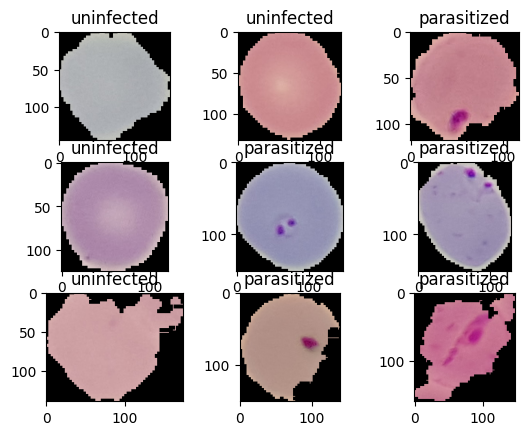

In [ ]:
for i,(img,lab) in enumerate(train_data.take(9)):
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(info.features['label'].int2str(lab))

In [ ]:
IMAGE_SIZE=(224,224)
def resizing_rescaling(img,label):
  return tf.image.resize(img,IMAGE_SIZE)/255.,label

In [ ]:
train_data=train_data.map(resizing_rescaling)
test_data=test_data.map(resizing_rescaling)
val_data=val_data.map(resizing_rescaling)

In [ ]:
val_data

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for im,la in train_data.take(1):
  print(im.shape)
  print(tf.math.reduce_max(im))
  print(la)

(224, 224, 3)
tf.Tensor(0.7877451, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
train_data=train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
# test_data=test_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_data=val_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
IMAGE_SHAPE=(224,224,3)
model=tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=IMAGE_SHAPE),

        tf.keras.layers.Conv2D(filters=8,kernel_size=5,strides=1,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(filters=16,kernel_size=5,strides=1,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),

        # tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=2,activation="relu"),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(32,activation="relu"),
        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 32)                1

In [ ]:
# bse=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# y_t,y_p=[1.,1.,1.,1.],[0.,0.,0.,10.]
# bse(y_t,y_p)

In [ ]:
from tensorflow.keras.metrics import TruePositives,TrueNegatives,FalseNegatives,FalsePositives,Precision,Recall,Accuracy
metrics=[
    TruePositives(name="tp"),TrueNegatives(name="tn"),FalseNegatives(name="fn"),
    FalsePositives(name="fp"),Precision(name="pre"),Recall(name="re"),
    "accuracy"
]

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer="adam",
    metrics=metrics
)

In [ ]:
hist=model.fit(train_data,validation_data=val_data,epochs=6,verbose=1)

Epoch 1/6
689/689 [==============================] - 52s 51ms/step - loss: 0.6227 - tp: 6720.0000 - tn: 7441.0000 - fn: 4302.0000 - fp: 3583.0000 - pre: 0.6522 - re: 0.6097 - accuracy: 0.6423
Epoch 2/6
689/689 [==============================] - 36s 50ms/step - loss: 0.2915 - tp: 10157.0000 - tn: 9550.0000 - fn: 866.0000 - fp: 1473.0000 - pre: 0.8733 - re: 0.9214 - accuracy: 0.8939
Epoch 3/6
689/689 [==============================] - 37s 52ms/step - loss: 0.1760 - tp: 10429.0000 - tn: 10222.0000 - fn: 594.0000 - fp: 801.0000 - pre: 0.9287 - re: 0.9461 - accuracy: 0.9367
Epoch 4/6
689/689 [==============================] - 38s 54ms/step - loss: 0.1343 - tp: 10522.0000 - tn: 10440.0000 - fn: 504.0000 - fp: 580.0000 - pre: 0.9478 - re: 0.9543 - accuracy: 0.9508
Epoch 5/6
689/689 [==============================] - 43s 62ms/step - loss: 0.0983 - tp: 10605.0000 - tn: 10626.0000 - fn: 418.0000 - fp: 397.0000 - pre: 0.9639 - re: 0.9621 - accuracy: 0.9630
Epoch 6/6
689/689 [=====================

2755

In [ ]:
# [i for i,j in test_data.take(1)]

In [ ]:
from sklearn.metrics import confusion_matrix
y_true=tf.constant([lab.numpy() for _,lab in test_data.take(len(test_data))])
pre_in=np.array([img.numpy() for img,_ in test_data.take(len(test_data))])
y_true_expand=tf.expand_dims(y_true,axis=1)
y_pre=model.predict(pre_in[0])

ValueError: ignored

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int32)>

In [ ]:
model.evaluate(pre_in)

87/87 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - tp: 0.0000e+00 - tn: 0.0000e+00 - fn: 0.0000e+00 - fp: 0.0000e+00 - pre: 0.0000e+00 - re: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
y_pre=[i.numpy() for i in tf.squeeze(y_pre,axis=1)]

In [ ]:
def to_return_pre(pre,ther=0.5):
  return list(map(lambda p:1 if p>0.5 else 0,pre))
y_pre=to_return_pre(y_pre)
confusion_matrix(y_true,y_pre)

array([[669, 698],
       [694, 694]])

In [ ]:
from sklearn.metrics import roc_curve
fp,tp,ther=roc_curve(y_true,y_pre)

In [ ]:
fp

array([0.        , 0.51060717, 1.        ])

Text(0.5, 1.0, 'epochs vs loss')

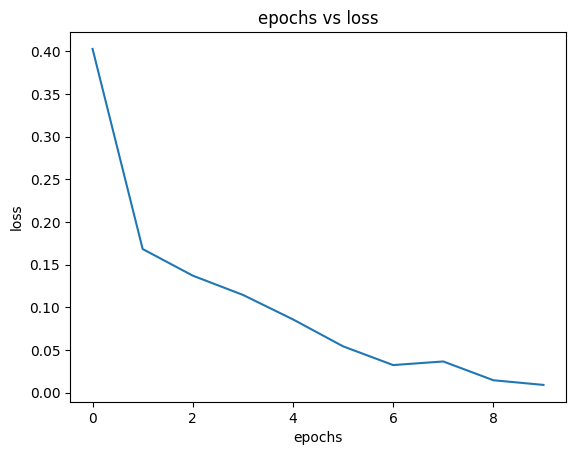

In [ ]:
plt.plot(hist.history["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("epochs vs loss")

In [ ]:
model.evaluate(test_data)

87/87 [==============================] - 18s 34ms/step - loss: 0.4629


0.4628903567790985

In [ ]:
model.predict(test_data.take(1))

In [ ]:
model.save("malaria_model.h5")

In [ ]:
loaded_model=tf.keras.models.load_model("malaria_model.h5")

### to create functional API

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Conv2D,Dropout,MaxPool2D,Flatten

In [ ]:
fun_in=Input(IMAGE_SHAPE)

x=Conv2D(16,5,activation="relu")(fun_in)
x=MaxPool2D(2,strides=2)(x)
x=BatchNormalization()(x)

x=Conv2D(32,5,activation="relu",strides=2)(x)
x=MaxPool2D(2,strides=2)(x)
x=BatchNormalization()(x)

x=Conv2D(64,5,activation="relu",strides=2)(x)
x=MaxPool2D(2,strides=2)(x)
x=BatchNormalization()(x)

x=Flatten()(x)
x=Dense(32,activation="relu")(x)
x=Dense(16,activation="relu")(x)
fun_out=Dense(1,activation="sigmoid")(x)

fun_model=Model(fun_in,fun_out,name="malaria_model")
fun_model.summary()

Model: "malaria_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 110, 110, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 53, 53, 32)        12832     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 26, 26, 32)     

In [ ]:
fun_in

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_8')>

In [ ]:
fun_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics="accuracy",
    optimizer="adam"
)

In [ ]:
fun_model.fit(train_data,validation_data=val_data,epochs=1)

689/689 [==============================] - 43s 54ms/step - loss: 0.3386 - accuracy: 0.8495


In [ ]:
##another way
fun_in=Input(shape=(224,224,3))
x=Conv2D(16,5,activation="relu")(fun_in)
x=MaxPool2D(2,strides=2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,5,activation="relu",strides=2)(x)
x=MaxPool2D(2,strides=2)(x)
x=BatchNormalization()(x)
x=Conv2D(64,5,activation="relu",strides=2)(x)
out=MaxPool2D(2,strides=2)(x)
# out=BatchNormalization()(x)
feature_extractor_model=Model(fun_in,out,name="feature_extractor_model")
x = feature_extractor_model(fun_in)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(fun_in, func_output, name = "Lenet_Model")
lenet_model_func.summary()


In [ ]:
lenet_model_func.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer="adam")
lenet_model_func.fit(train_data,epochs=1)

In [ ]:
## another way to create model
feature_extractor_seq_model = tf.keras.Sequential([
                             Input(shape = (224, 224, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),



])
# feature_extractor_seq_model.summary()
func_input = Input(shape = (224, 224, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

### Custom Layers

In [ ]:
class CustomDense(tf.keras.layers.Layer):
  def __init__(self,output_units,activation):
    super(CustomDense,self).__init__()
    self.activation=activation
    self.output_units=output_units
  def build(self,input_features_shape):
    # print('INPUT FEATURES SHAPE    ==='*20)
    # print(input_features_shape)
    # print('==='*20)
    self.w=self.add_weight(shape=(input_features_shape[-1],self.output_units),trainable=True)
    self.b=self.add_weight(shape=(self.output_units,),trainable=True)
  def call(self,input_features):
    # print('INPUT FEATURES SHAPE     ==='*20)
    # print(input_features.shape)
    # print('==='*20)
    # print('INPUT FEATURES TYPE     ==='*20)
    # print(type(input_features))
    # print('==='*20)

    pre_out=tf.matmul(input_features,self.w)+self.b
    if self.activation=="relu":
      return tf.nn.relu(pre_out)
    elif self.activation=="sigmoid":
      return tf.math.sigmoid(pre_out)
    elif self.activation=="tanh":
      return tf.math.tanh(pre_out)

    return pre_out

In [ ]:
IMAGE_SHAPE=(224,224,3)
model=tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=IMAGE_SHAPE),

        tf.keras.layers.Conv2D(filters=8,kernel_size=5,strides=1,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(filters=16,kernel_size=5,strides=1,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=2,activation="relu"),
        tf.keras.layers.Flatten(),

        CustomDense(64,activation="relu"),
        CustomDense(32,activation="relu"),
        CustomDense(1,activation="sigmoid")
    ]
)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 220, 220, 8)       608       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 110, 110, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 106, 106, 16)      3216      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 53, 53, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 25, 25, 32)        12832     
                                                                 
 flatten_19 (Flatten)        (None, 20000)            

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
model.fit(train_data,epochs=1)

INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===INPUT FEATURES SHAPE     ===
(None, 20000)
INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE     ===INPUT FEATURES TYPE 

## callbacks

In [ ]:
from tensorflow.keras.callbacks import Callback
class CustomCallbacks(Callback):
  def on_epoch_end(self,epoch,logs):
    print(f' epoch {epoch} and loss is {logs["loss"]}')
  def on_batch_end(self,batch,logs):
    print(f' epoch {batch} and loss is {logs}')

In [ ]:
model.compile(metrics=metrics,loss=tf.keras.losses.BinaryCrossentropy())
model.fit(train_data,epochs=2,callbacks=[CustomCallbacks()])

Epoch 1/2
 epoch 0 and loss is {'loss': 0.7024012804031372, 'tp': 0.0, 'tn': 14.0, 'fn': 18.0, 'fp': 0.0, 'pre': 0.0, 're': 0.0, 'accuracy': 0.4375}
  5/689 [..............................] - ETA: 36s - loss: 1.6287 - tp: 53.0000 - tn: 33.0000 - fn: 31.0000 - fp: 43.0000 - pre: 0.5521 - re: 0.6310 - accuracy: 0.5375 epoch 5 and loss is {'loss': 1.4789422750473022, 'tp': 65.0, 'tn': 33.0, 'fn': 31.0, 'fp': 63.0, 'pre': 0.5078125, 're': 0.6770833134651184, 'accuracy': 0.5104166865348816}
 epoch 6 and loss is {'loss': 1.3657439947128296, 'tp': 75.0, 'tn': 42.0, 'fn': 35.0, 'fp': 72.0, 'pre': 0.5102040767669678, 're': 0.6818181872367859, 'accuracy': 0.5223214030265808}
  8/689 [..............................] - ETA: 35s - loss: 1.2844 - tp: 79.0000 - tn: 50.0000 - fn: 52.0000 - fp: 75.0000 - pre: 0.5130 - re: 0.6031 - accuracy: 0.5039 epoch 8 and loss is {'loss': 1.2183864116668701, 'tp': 95.0, 'tn': 50.0, 'fn': 52.0, 'fp': 91.0, 'pre': 0.5107526779174805, 're': 0.646258533000946, 'accurac

In [ ]:
## csv logger call backs
csvlogger=tf.keras.callbacks.CSVLogger("logger.csv",append=False)
model.compile(metrics=metrics,loss=tf.keras.losses.BinaryCrossentropy())
model.fit(train_data,epochs=1,callbacks=[csvlogger])

689/689 [==============================] - 56s 75ms/step - loss: 0.2054 - tp: 20597.0000 - tn: 20133.0000 - fn: 1451.0000 - fp: 1911.0000 - pre: 0.9151 - re: 0.9342 - accuracy: 0.9321


In [ ]:
## early stoping callbacks
early_stoping=tf.keras.callbacks.EarlyStopping(monitor="tn",min_delta=100,patience=1,mode="max",restore_best_weights=True)
model.compile(metrics=metrics,loss=tf.keras.losses.BinaryCrossentropy())
model.fit(train_data,epochs=3,callbacks=[early_stoping])

Epoch 1/3
689/689 [==============================] - 40s 50ms/step - loss: 0.1675 - tp: 21212.0000 - tn: 20464.0000 - fn: 839.0000 - fp: 1577.0000 - pre: 0.9308 - re: 0.9620 - accuracy: 0.9467
Epoch 2/3
689/689 [==============================] - 35s 50ms/step - loss: 0.1501 - tp: 10652.0000 - tn: 10363.0000 - fn: 375.0000 - fp: 656.0000 - pre: 0.9420 - re: 0.9660 - accuracy: 0.9532


In [ ]:
## lr_schduler
def schdule(epoch,lr):

  if epoch<2:
    print(f'=====   lr {lr}  epoch  {epoch}')
    return lr
  lr=lr/10
  print(f'=====   lr {lr}  epoch  {epoch}')
  return lr
lr_schduler=tf.keras.callbacks.LearningRateScheduler(schdule)

In [ ]:
model.compile(metrics=metrics,loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
model.fit(train_data,epochs=3,callbacks=[lr_schduler])

In [ ]:
### model checkpoint callback
ckpt_cb=tf.keras.callbacks.ModelCheckpoint(filepath="ckpt/"
 ,monitor="tn",save_best_only=True,save_weights_only=True,save_freq="epoch")

In [ ]:
model.compile(metrics=metrics,loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
model.fit(train_data,epochs=3,callbacks=[ckpt_cb])

Epoch 1/3
689/689 [==============================] - 40s 51ms/step - loss: 0.6954 - tp: 7852.0000 - tn: 4930.0000 - fn: 4924.0000 - fp: 7764.0000 - pre: 0.5028 - re: 0.6146 - accuracy: 0.5006
Epoch 2/3
689/689 [==============================] - 38s 54ms/step - loss: 0.6956 - tp: 5515.0000 - tn: 5468.0000 - fn: 5506.0000 - fp: 5557.0000 - pre: 0.4981 - re: 0.5004 - accuracy: 0.4982
Epoch 3/3
689/689 [==============================] - 36s 51ms/step - loss: 0.6952 - tp: 5487.0000 - tn: 5502.0000 - fn: 5536.0000 - fp: 5521.0000 - pre: 0.4985 - re: 0.4978 - accuracy: 0.4985


In [ ]:
### ReduceLROnPlateau callback
reduceLrOnplateau=tf.keras.callbacks.ReduceLROnPlateau(monitor="tn",patience=1,factor=0.1,verbose=1,min_delta=100,mode="max")
model.compile(metrics=metrics,loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
model.fit(train_data,epochs=3,callbacks=[reduceLrOnplateau])

Epoch 1/3
689/689 [==============================] - 40s 50ms/step - loss: 0.6947 - tp: 11195.0000 - tn: 10838.0000 - fn: 10854.0000 - fp: 11205.0000 - pre: 0.4998 - re: 0.5077 - accuracy: 0.5010 - lr: 0.1000
Epoch 2/3
687/689 [============================>.] - ETA: 0s - loss: 0.6946 - tp: 5671.0000 - tn: 5397.0000 - fn: 5323.0000 - fp: 5593.0000 - pre: 0.5035 - re: 0.5158 - accuracy: 0.5035
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
689/689 [==============================] - 36s 49ms/step - loss: 0.6946 - tp: 5671.0000 - tn: 5431.0000 - fn: 5351.0000 - fp: 5593.0000 - pre: 0.5035 - re: 0.5145 - accuracy: 0.5036 - lr: 0.1000
Epoch 3/3
687/689 [============================>.] - ETA: 0s - loss: 0.6938 - tp: 4753.0000 - tn: 6142.0000 - fn: 6242.0000 - fp: 4847.0000 - pre: 0.4951 - re: 0.4323 - accuracy: 0.4956
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
689/689 [==============================] - 35s 49ms/step - loss: 0.6938 -